# MAT 388, HW4

In [1]:
import yfinance as yf
import numpy as np
import pandas as pd

import urllib
import scipy.io

import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, SimpleRNN

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split, KFold
from sklearn.decomposition import PCA

import gc

2022-12-19 21:29:53.829259: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/usr/local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Q1

For this question we are goint to use [CELEB_A](https://www.tensorflow.org/datasets/catalog/celeb_a) dataset through [tensorflow datasets](https://www.tensorflow.org/datasets).

1. Ingest the data, and select 10000 images from the dataset. Put the images under a variable called `X` and class labels (attributes) into `y`.
2. Build a neural network model for `X` against `Glasses` attribute in `y`.
3. Test the accuracy of your model using a 5-fold cross-validation. (I want a %95 confidence interval on the returned result using a t-test as I did in one of my lectures.)
4. Repeat Steps 2 and 3 for `Male` and `Bangs` attributes.
5. Compare your results for `Glasses`, `Male` and `Bangs`. Which one is better? Why? Explain.

2022-12-19 21:30:16.264438: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


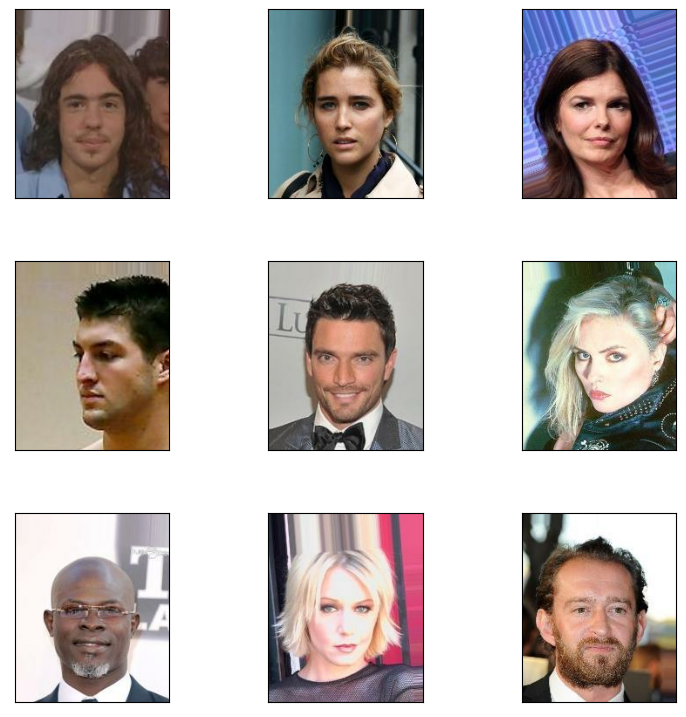

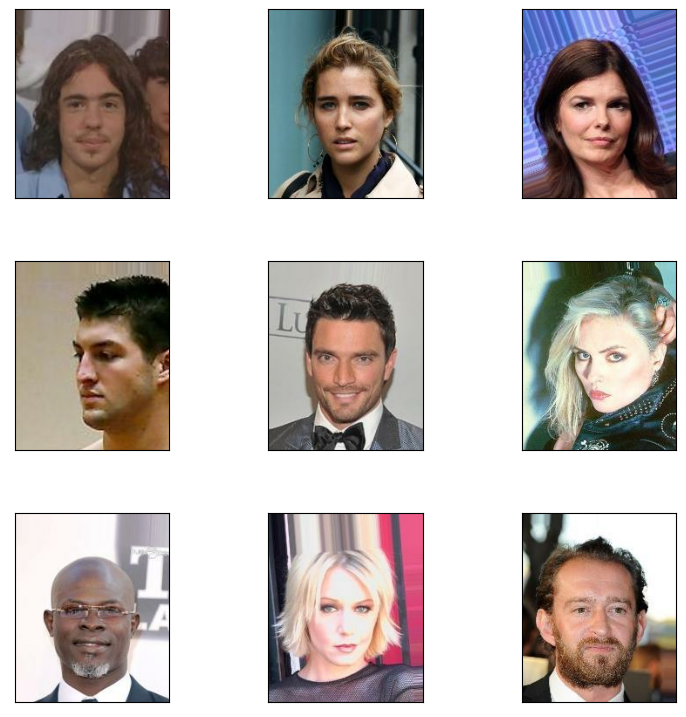

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds

(train, test), info = tfds.load('celeb_a', split=['train','test'], with_info=True, shuffle_files=True)
tfds.show_examples(train,info)

In [3]:
def tfGetData(df,N,attr):
    X= []
    y = []
    fn = {True: 1, False: 0}
    for u in df.take(N):
        X.append(u['image'].numpy().reshape((218*178*3)))
        y.append(fn.get(u['attributes'][attr].numpy(),0))
    return X, y

In [4]:
X, y = tfGetData(train, 10000, 'Eyeglasses')

In [5]:
X = np.stack(X, axis=0)

In [7]:
X.shape

(10000, 116412)

In [9]:
pca = PCA(n_components=1000)
Xr = pd.DataFrame(pca.fit_transform(X))

In [75]:
y = np.stack(y)
y.shape

(10000,)

In [8]:
Xr

NameError: name 'Xr' is not defined

In [ ]:
X.shape

In [ ]:
y = np.stack(y, axis=0)

In [ ]:
def build_model(X, y, attribute):
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Flatten(input_shape=(X.shape[1],)))
  model.add(tf.keras.layers.Dense(64, activation='relu'))
  model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

In [78]:
from sklearn.model_selection import KFold
from scipy.stats import ttest_ind

kfold = KFold(n_splits=5)
scores = []

for train_index, test_index in kfold.split(X):
  model = build_model(X[train_index], y[train_index], 'Glasses')
  model.fit(X[train_index], y[train_index], epochs=10, verbose=0)
  _, accuracy = model.evaluate(X[test_index], y[test_index], verbose=0)
  scores.append(accuracy)

mean = np.mean(scores)
std = np.std(scores)

t_test = ttest_ind(scores, [mean] * len(scores))
confidence_interval = (mean - std * t_test.statistic / np.sqrt(len(scores)), mean + std * t_test.statistic / np.sqrt(len(scores)))

print(f'Accuracy: {mean * 100:.2f}% ({confidence_interval[0] * 100:.2f}%, {confidence_interval[1] * 100:.2f}%)')

KeyboardInterrupt: 

## Q2

For this question use the [Hyperspectral Image of Kennedy Space Center](https://www.ehu.eus/ccwintco/index.php/Hyperspectral_Remote_Sensing_Scenes#Kennedy_Space_Center_.28KSC.29).

1. Ingest the image data directly from the web. (No local files!)
2. Ingest the ground truth data directly from the web. (No local files!)
4. Build a convolutional neural network (preferably using [this](https://keras.io/api/layers/convolution_layers/) and/or [this](https://keras.io/api/layers/recurrent_layers/conv_lstm2d/)) model.
5. Test the accuracy of the model using a 5-fold cross-validation. (I want a %95 confidence interval on the returned result using a t-test as I did in one of my lectures.)

In [9]:
gc.collect()

487

In [63]:
ksc_url ='http://www.ehu.es/ccwintco/uploads/2/26/KSC.mat'
urllib.request.urlretrieve(ksc_url,"ksc_data.mat")
ksc = scipy.io.loadmat("ksc_data.mat")

In [64]:
ksc_gt_url = "http://www.ehu.es/ccwintco/uploads/a/a6/KSC_gt.mat"
urllib.request.urlretrieve(ksc_gt_url,"ksc_gt_data.mat")
ksc_gt = scipy.io.loadmat("ksc_gt_data.mat")

In [45]:
X = ksc['KSC']
y = ksc_gt['KSC_gt']

(314368, 176)

In [57]:
binarizer = LabelBinarizer()
y = binarizer.fit_transform(y)
y

array([[1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0]])

In [47]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [58]:
model = Sequential()
model.add(Conv2D(3, 2, activation='softmax', input_shape=(512,614,1,)))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(10, activation='sigmoid'))
model.compile(loss = 'binary_crossentropy', 
              optimizer = 'adamax', 
              metrics = ['accuracy'])

Epoch 1/5
7860/7860 [==============================] - 21s 2ms/step - loss: 11.4121 - accuracy: 0.0024
Epoch 2/5
7307/7860 [==========================>...] - ETA: 1s - loss: 4.8774 - accuracy: 0.0024

KeyboardInterrupt: 

## Q3

For this question we are going to use the time series of [Wheat Futures](https://finance.yahoo.com/quote/ZW=F/) from Yahoo Finance.

1. Ingest the data using [yfinance](https://pypi.org/project/yfinance/) Start from Jan 1, 2010 until Dec 31, 2021.
2. Construct [a RNN and/or a LSTM](https://keras.io/api/layers/recurrent_layers/) model on the data.
3. Test your model on the wheat futures data from Jan 1, 2022 to today using a 5-fold cross-validation. Did your model work? Explain.

In [6]:
data = yf.download('ZW=F', start='2010-01-01', end='2021-12-31')
data

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,544.75,561.25,544.00,557.75,557.75,41278
2010-01-05,556.75,561.50,552.00,553.00,553.00,36720
2010-01-06,552.00,567.75,551.00,567.25,567.25,38503
2010-01-07,566.50,568.00,556.00,557.75,557.75,33873
2010-01-08,557.50,570.00,545.25,568.50,568.50,33873
...,...,...,...,...,...,...
2021-12-23,812.50,820.50,808.25,814.75,814.75,36615
2021-12-27,817.50,824.00,802.50,804.00,804.00,30210
2021-12-28,805.75,808.00,781.75,783.50,783.50,41877


In [7]:
def reshape_data(data):
    y = data['Close'].values
    y = y.reshape(y.shape[0], 1)
    X = data['Open'].values
    X = X.reshape(X.shape[0], 1)
    return X, y

In [8]:
X , y = reshape_data(data)

In [9]:
model = Sequential()
model.add(SimpleRNN(128, activation="relu", input_shape=(1, 1)))
model.add(Dropout(0.3))
model.add(Dense(1, activation = 'relu'))

model.compile(loss='mape', optimizer='adam', metrics = ['mse'])

2022-12-19 20:14:04.061951: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [11]:
history = model.fit(X, y, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
76/76 [==============================] - 0s 5ms/step - loss: 9.8613 - mse: 5231.2798 - val_loss: 3.4963 - val_mse: 556.6269
Epoch 2/10
76/76 [==============================] - 0s 3ms/step - loss: 9.4484 - mse: 4922.9766 - val_loss: 3.0928 - val_mse: 452.7316
Epoch 3/10
76/76 [==============================] - 0s 3ms/step - loss: 9.6148 - mse: 4828.4609 - val_loss: 2.5982 - val_mse: 342.0821
Epoch 4/10
76/76 [==============================] - 0s 3ms/step - loss: 9.3894 - mse: 4953.9995 - val_loss: 2.3210 - val_mse: 286.8243
Epoch 5/10
76/76 [==============================] - 0s 3ms/step - loss: 9.2764 - mse: 4821.3521 - val_loss: 2.3421 - val_mse: 290.9133
Epoch 6/10
76/76 [==============================] - 0s 3ms/step - loss: 9.5474 - mse: 4861.2402 - val_loss: 2.8611 - val_mse: 398.8837
Epoch 7/10
76/76 [==============================] - 0s 3ms/step - loss: 9.4052 - mse: 4801.7734 - val_loss: 1.8384 - val_mse: 200.6925
Epoch 8/10
76/76 [==============================] - 0s 

In [12]:
test_data = yf.download('ZW=F', start='2022-01-01')
test_data = np.array_split(test_data, 5)

[*********************100%***********************]  1 of 1 completed


In [14]:
res = []
for i in range(5):
    X_test, y_test = reshape_data(test_data[i])
    y_pred = model.predict(X_test)
    res.append( pd.DataFrame({'X_test': X_test.reshape(X_test.shape[0]), 
                        'Y_test': y_test.reshape(y_test.shape[0]), 
                        'Y_pred': y_pred.reshape(y_pred.shape[0])}))
res

2/2 [==============================] - 0s 4ms/step


[     X_test   Y_test       Y_pred
 0    774.00   758.00   766.232483
 1    758.00   770.00   750.413208
 2    771.00   760.75   763.266418
 3    761.75   746.00   754.120850
 4    748.00   758.50   740.526184
 5    760.75   762.00   753.132141
 6    761.75   770.25   754.120850
 7    768.00   757.75   760.300232
 8    757.00   746.75   749.424500
 9    746.00   741.50   738.548767
 10   742.25   769.00   734.841125
 11   772.00   796.50   764.255066
 12   794.00   790.25   786.006531
 13   788.00   780.00   780.074280
 14   794.00   800.50   786.006531
 15   801.00   818.00   792.927429
 16   817.25   795.00   808.993958
 17   794.25   777.00   786.253723
 18   777.25   786.25   769.445740
 19   793.00   761.25   785.017822
 20   762.50   769.00   754.862366
 21   770.00   755.00   762.277649
 22   754.00   751.75   746.458435
 23   754.75   763.25   747.199951
 24   776.00   768.75   768.209900
 25   771.25   778.75   763.513611
 26   779.50   785.00   771.670349
 27   785.50   771.5

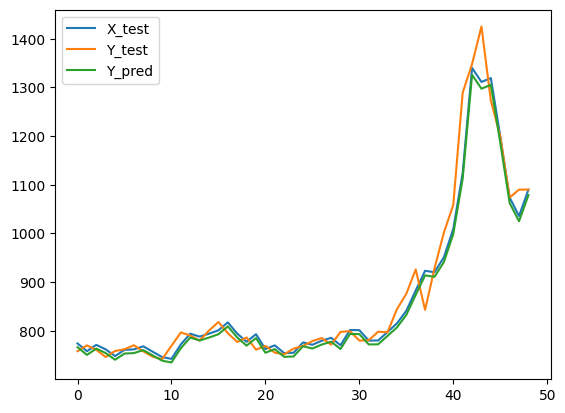

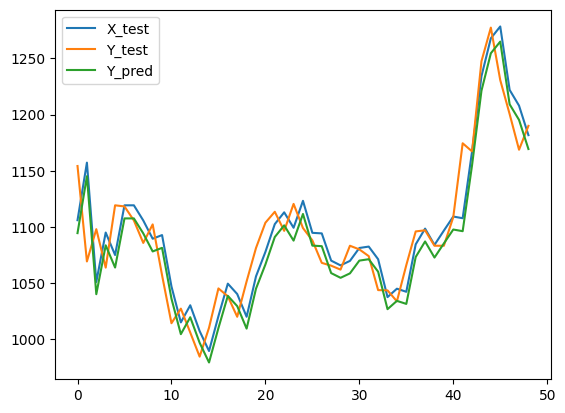

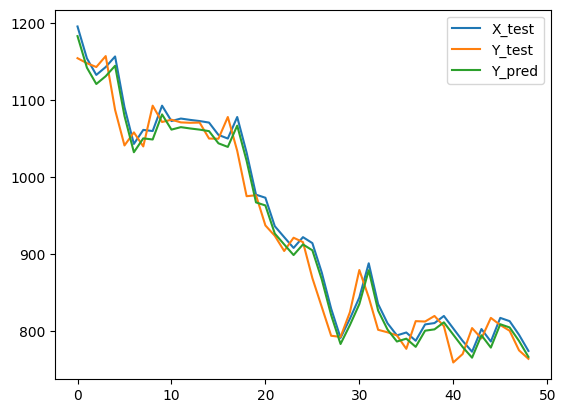

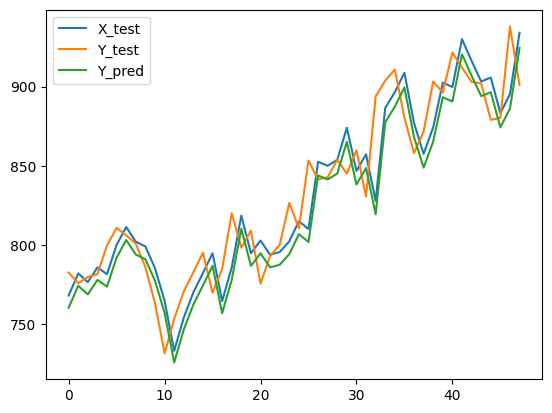

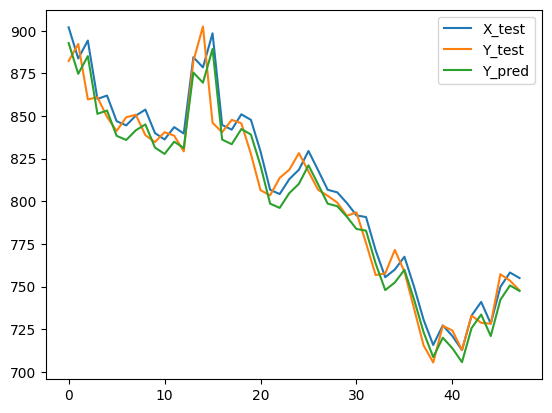

In [15]:
for i in range(5):
    res[i].plot()

The model **did not** work. We see the case is quite similar to the case when we tried to predict price time-series in class where the NN learns the X_train's trends and amplitude well but fails the predict the y_test which is basically useless in terms of a ML model.

## Q4

For this question, we are going to use [Consumer Complaints Dataset](https://raw.githubusercontent.com/plotly/datasets/master/26k-consumer-complaints.csv).

1. Ingest the dataset. We are only going to use the columns `Issue` and `Timely Response?`.
2. Convert the values in the issue column to vectors using [Count Vectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) from `scikit-learn`. Similarly, binarize the column `Timely Response` using [Label Binarizer](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelBinarizer.html).
3. Split your dataset into train and test.
3. Construct an an appropriate neural network model on the train set.
4. Test your model on the test set. Did your model work? Explain.

In [16]:
data = pd.read_csv("https://raw.githubusercontent.com/plotly/datasets/master/26k-consumer-complaints.csv")
data = data[['Issue', 'Timely response?']]
data.dropna(inplace=True)
data

,Issue,Timely response?
0,Communication tactics,Yes
1,Cont'd attempts collect debt not owed,Yes
2,"Application, originator, mortgage broker",Yes
3,Other,Yes
4,Cont'd attempts collect debt not owed,Yes
...,...,...
28151,Cont'd attempts collect debt not owed,Yes
28152,Taking out the loan or lease,Yes
28153,"Loan servicing, payments, escrow account",Yes
28154,Can't stop charges to bank account,Yes


In [17]:
cv = CountVectorizer()
X = cv.fit_transform(data['Issue'])

In [18]:
lb = LabelBinarizer()
y = lb.fit_transform(data['Timely response?'])

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.sort_indices()
X_test.sort_indices()

In [20]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(32, activation='relu', input_shape=(X.shape[1],)))
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(y.shape[1], activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model on the train set
model.fit(X_train, y_train, epochs=10, verbose=0)

# Evaluate the model on the test set
_, accuracy = model.evaluate(X_test, y_test, verbose=0)

print(f'Test accuracy: {accuracy * 100:.2f}%')

Test accuracy: 97.37%


In [21]:
y_pred = model.predict(X_test)
y_pred = [[1] if yp == [1.] else [0] for yp in y_pred]
y_pred

176/176 [==============================] - 0s 1ms/step


[[1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1]

In [22]:
y_test

array([[1],
       [1],
       [1],
       ...,
       [1],
       [1],
       [1]])

In [23]:
from sklearn.metrics import classification_report

In [24]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       148
           1       0.97      1.00      0.99      5483

    accuracy                           0.97      5631
   macro avg       0.49      0.50      0.49      5631
weighted avg       0.95      0.97      0.96      5631



/usr/local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


This model **did not** work as well. Since the dataset is heavily asymmetric the model fails to differentiate the classes but still seems to perform well when we look at the accuracy. However after taking a look at the classification report we see that the NN simply does this by classifying every single input as class [1] since our data is heavily skewed towards that class.